In [3]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.deephedging import DeepHedging
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Single control:

In [4]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 100

In [5]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 5
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [6]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [adam_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [7]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adam, lr=0.00020, sigma=[0], train=0.497, test=0.479: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


In [8]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
ladam_control = LAdam(ocp.control.parameters(), lr=2e-3, sigma=2e-4)
ladam = [adam_w, ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [9]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LAdam, lr=0.00020, sigma=[0], train=0.305, test=0.292: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]    


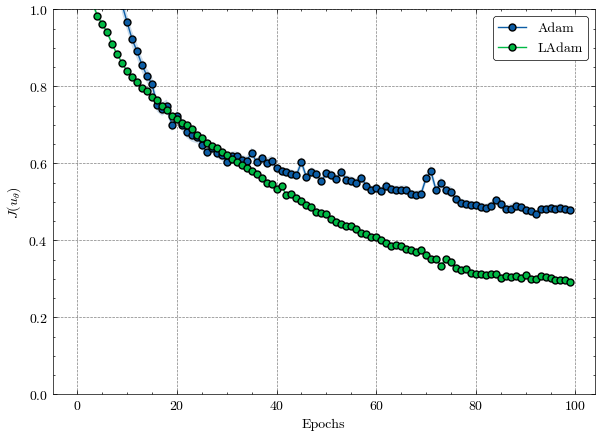

In [11]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    name="Adam",
    ylim=(0, 1),
)

In [30]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
adadelta_control = optim.Adadelta(ocp.control.parameters(), lr=5e-1, rho=0.95)
adadelta = [adadelta_w, adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [31]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adadelta, lr=0.05000, sigma=[0], train=0.121, test=0.155: 100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


In [32]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ladadelta_control = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=5e-3)
ladadelta = [adadelta_w, ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [33]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LAdadelta, lr=0.05000, sigma=[0], train=0.722, test=0.701: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]   


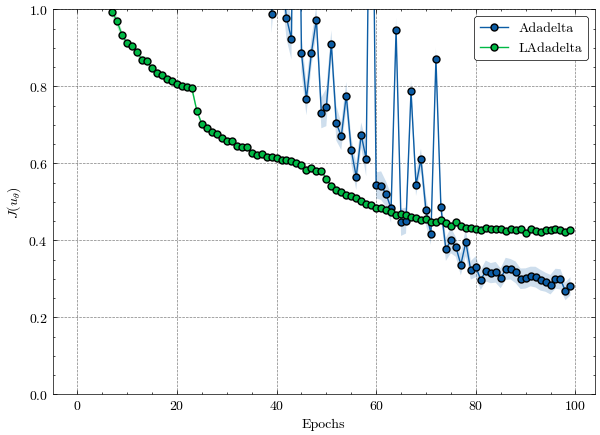

In [28]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
    ylim=(0, 1),
)

In [34]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
rmsprop_control = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
rmsprop = [rmsprop_w, rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    rmsprop_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [35]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, RMSprop, lr=0.00020, sigma=[0], train=0.325, test=0.336: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


In [36]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
lrmsprop_control = LRMSprop(ocp.control.parameters(), lr=2e-3, sigma=2e-4)
lrmsprop = [rmsprop_w, lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    lrmsprop_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [37]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LRMSprop, lr=0.00020, sigma=[0], train=0.330, test=0.310: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s]    


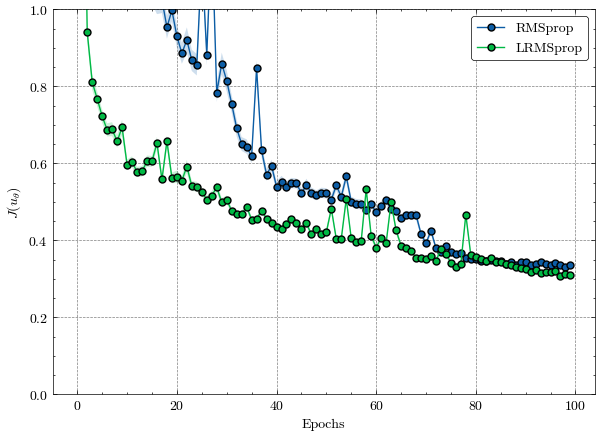

In [38]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    name="RMSprop",
    ylim=(0, 1),
)

### Multiple controls:

In [14]:
model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

epochs = 200

In [15]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
adam_control = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
adam = [adam_w, *adam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in adam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [16]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.00020, sigma=[0], train=0.585, test=0.565: 100%|██████████| 200/200 [00:24<00:00,  8.33it/s]


In [17]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ladam_control = [
    LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control
]
ladam = [ladam_w, *ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in ladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [18]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdam, lr=0.00020, sigma=[0], train=0.391, test=0.389: 100%|██████████| 200/200 [00:22<00:00,  8.89it/s]     


In [19]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ll = 30
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [ladam_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [20]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.00020, sigma=[0], train=0.385, test=0.393: 100%|██████████| 200/200 [00:20<00:00,  9.95it/s]


In [21]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ll = 90
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [ladam_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [22]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.00020, sigma=[0], train=0.336, test=0.315: 100%|██████████| 200/200 [00:21<00:00,  9.13it/s]     


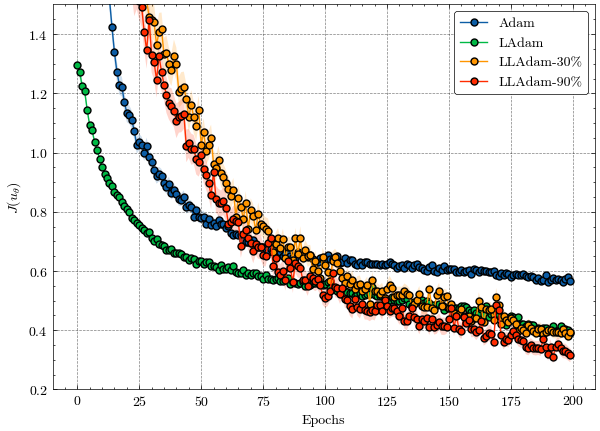

In [23]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
    ylim=(0.2, 1.5),
)

In [24]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
adadelta_control = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
adadelta = [adadelta_w, *adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in adadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [25]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adadelta, lr=0.05000, sigma=[0], train=0.644, test=0.673: 100%|██████████| 200/200 [00:20<00:00,  9.54it/s]


In [26]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ladadelta_control = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
ladadelta = [adadelta_w, *ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in ladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [27]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdadelta, lr=0.05000, sigma=[0], train=0.204, test=0.178: 100%|██████████| 200/200 [00:21<00:00,  9.47it/s]    


In [28]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ll = 30
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [adadelta_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [29]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.05000, sigma=[0], train=0.485, test=0.471: 100%|██████████| 200/200 [00:22<00:00,  9.01it/s]


In [30]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ll = 90
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [adadelta_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [31]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.05000, sigma=[0], train=0.200, test=0.181: 100%|██████████| 200/200 [00:27<00:00,  7.29it/s]    


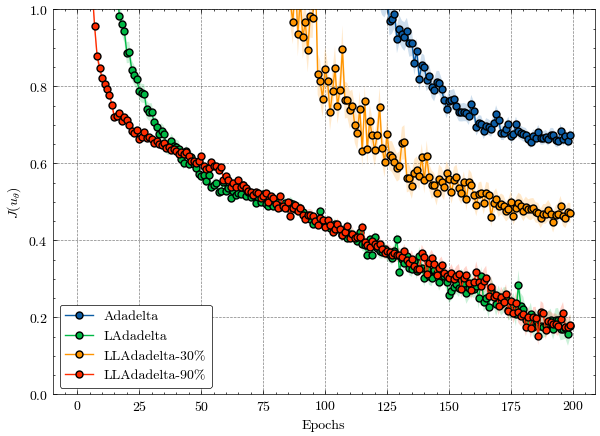

In [32]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
    ylim=(0, 1),
)

In [33]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
rmsprop_control = [
    optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control
]
rmsprop = [rmsprop_w, *rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in rmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [34]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, RMSprop, lr=0.00020, sigma=[0], train=0.675, test=0.667: 100%|██████████| 200/200 [00:22<00:00,  8.73it/s]


In [35]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
lrmsprop_control = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]
lrmsprop = [rmsprop_w, *lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [36]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LRMSprop, lr=0.00020, sigma=[0], train=0.320, test=0.385: 100%|██████████| 200/200 [00:22<00:00,  8.87it/s]    


In [37]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
ll = 30
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [rmsprop_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [38]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.00020, sigma=[0], train=0.313, test=0.325: 100%|██████████| 200/200 [00:24<00:00,  8.13it/s]


In [39]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
ll = 90
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [rmsprop_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [40]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.00020, sigma=[0], train=0.406, test=0.403: 100%|██████████| 200/200 [00:26<00:00,  7.52it/s]    


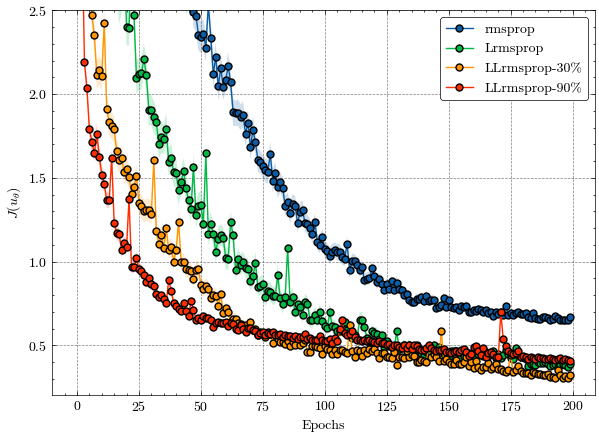

In [41]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="rmsprop",
    ylim=(0.2, 2.5),
)

### Sample trajectory:

In [42]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 1
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [43]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [adam_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [44]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adam, lr=0.00020, sigma=[0], train=0.081, test=0.081: 100%|██████████| 200/200 [00:56<00:00,  3.55it/s]


In [45]:
S1, S2, V, u = ocp.sample_traj(1)

Sampling trajectories: 100%|██████████| 50/50 [00:00<00:00, 8136.70it/s]


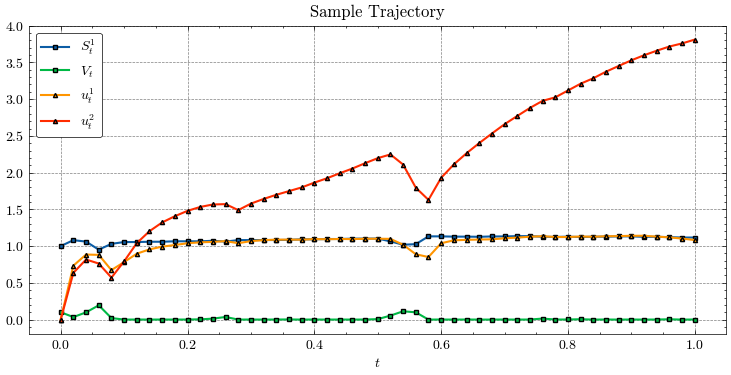

In [46]:
fig = plt.figure(figsize=(9, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    S1.flatten().detach().numpy(),
    label=r"$S_t^1$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, V.flatten().detach().numpy(), label=r"$V_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t,
    u[:, :, 0].flatten().detach().numpy(),
    label=r"$u_t^1$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t,
    u[:, :, 1].flatten().detach().numpy(),
    label=r"$u_t^2$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/deephedging/Sample_traj_N50.pdf")
plt.show()
plt.close()